In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm
from sklearn.decomposition import PCA


def distance(a, b):
    return np.linalg.norm(a - b)


def find_df_inside_sphere(df, center, R):
    return df[df.apply(lambda x: distance(x, center) < R, axis=1)]


def df_diff(df_a, df_b):
    merged = df_a.merge(df_b, indicator=True, how='outer')
    merged = merged[merged['_merge'] == 'left_only']
    columns = [col for col in df_a.columns if not col == '_merge']
    return merged[columns]


def draw_pca_projection(dataset, labels):
    pca = PCA(n_components=2)
    transformed = pca.fit_transform(dataset)

    colors = cm.rainbow(np.linspace(0, 1, len(labels)))

    for labels_set, color in zip(labels, colors):
        cluster = np.take(transformed, labels_set, axis=0)
        plt.scatter(cluster[:, 0], cluster[:, 1], c=color)

    plt.show()


class ForelClusteringModel(object):
    """
    Forel clustering. Unfortunately, only Russian wiki available: 
    https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D1%81%D0%B5%D0%BC%D0%B5%D0%B9%D1%81%D1%82%D0%B2%D0%B0_FOREL
    
    Arguments:
    1) dataset - pandas dataset with numeric features
    2) clusters_num - desired number of clusters
    
    Return value:
    list of index arrays, each of them contains indices of elements that were placed into particular cluster
    
    Example:
    input - ForelClusteringModel(pd.DataFrame({'a': [1, 2, 3, 4], 'b': [1, 2, 3, 4]}, 2)()
    output - [[0, 1], [2, 3]]
    """
    
    def __init__(self, dataset, clusters_num):
        minimum = dataset.min()
        self.dataframe = (dataset - minimum) / (dataset.max() - minimum)
        self.K = clusters_num
        self.labels = []
    
    def __call__(self):
        R = np.sqrt(len(self.dataframe)) / 2
        df = self.dataframe.copy(deep=True)

        while len(self.labels) < self.K or len(df) > 0:
            if len(df) == 0:
                self.labels = []
                R -= (self.K + 1) * R / 10
                df = self.dataframe.copy(deep=True)

            center = df.sample()
            cluster_df = find_df_inside_sphere(df, center, R)

            while True:
                center = cluster_df.mean()
                new_cluster_df = find_df_inside_sphere(cluster_df, center, R)

                if len(new_cluster_df) > 0 and len(df_diff(cluster_df, new_cluster_df)) == 0:
                    self.labels.append(new_cluster_df.index)
                    break
                elif len(new_cluster_df) == 0:
                    break

                cluster_df = new_cluster_df

            if len(new_cluster_df) > 0:
                df = df_diff(df, new_cluster_df)
        
        return self.labels

labels: [[0, 1, 2, 3, 4, 5], [6, 7, 8]]


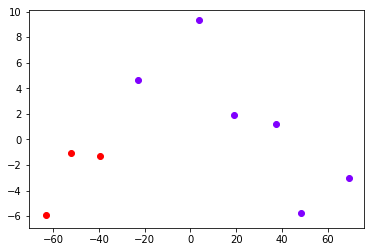

In [67]:
dataset = pd.DataFrame({'x1': [1, 5, 12, 23, 34, 53, 66, 69, 78], 
                        'x2': [88, 77, 66, 56, 43, 34, 31, 23, 22],
                        'x3': [11, 32, 34, 45, 48, 65, 77, 88, 96]})

model = ForelClusteringModel(dataset, 2)
labels = model()
print('labels:', [list(x) for x in labels])
draw_pca_projection(dataset, labels)

labels: [[5, 6, 7, 8], [0, 1, 2], [3, 4]]


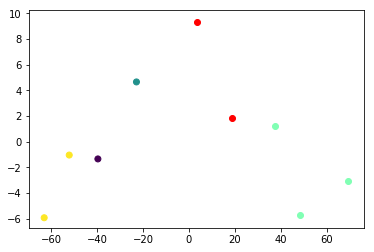

In [68]:
model = ForelClusteringModel(dataset, 3)
labels = model()
print('labels:', [list(x) for x in labels])
draw_pca_projection(dataset, labels)